# Honor Statement

Name: Zhuoran Wu

E-mail: <zw118@georgetown.edu>

Platform: Windows

In accordance with the class policies and Georgetown's Honor Code,
I certify that, with the exceptions of the class resources and those
items noted below, I have neither given nor received any assistance
on this project.

In [1]:
# Import Library

%matplotlib inline

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import itertools

from string import printable
from keras import backend as K
from skimage.transform import resize
from keras.datasets import fashion_mnist
from keras import regularizers
from keras import callbacks
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization, Lambda, Convolution1D, Convolution2D, ELU, concatenate
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping  

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# 1 Autoencoder

A convolutional autoencoder is a particular flavor of autoencoder where we use convolutional layers instead of dense layers. We have previously applied autoencoders to images using only Dense layers and the result worked fairly well. However, the local spatial correlations of images imply that we should be able to do better using convolutional layers instead of Dense layers.

Build and fit a convolutional autoencoder for the Fashion MNIST dataset. The components of this network will be many of the same pieces we've used with convolutional classification networks: Conv2D, MaxPooling, and so on. The encoder part of the network should run the input image through a few convolutional layers of your choice. The decoder part of the network will utilize UpSampling2D to get the representation back to the original image size.

An example to guide your thinking can be found toward the bottom of this
post https://blog.keras.io/building-autoencoders-in-keras.html.

After training your network, visualize some examples of input images and
their decoded reconstruction.

In [2]:
# Autoencoder

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Data normalization

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [3]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same', use_bias=False)(input_img)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(encoded)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid', use_bias=False)(x)
x = BatchNormalization(axis=-1)(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', use_bias=False)(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        288       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
__________

In [4]:
eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

autoencoder_history = autoencoder.fit(x_train, x_train,
                                      epochs=100,
                                      batch_size=64,
                                      validation_data=(x_test, x_test),
                                      callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 329s 5ms/step - loss: 0.3156 - val_loss: 0.3020
Epoch 2/100
60000/60000 [==============================] - 338s 6ms/step - loss: 0.2868 - val_loss: 0.2957
Epoch 3/100
60000/60000 [==============================] - 335s 6ms/step - loss: 0.2818 - val_loss: 0.2821
Epoch 4/100
60000/60000 [==============================] - 412s 7ms/step - loss: 0.2789 - val_loss: 0.2786
Epoch 5/100
60000/60000 [==============================] - 359s 6ms/step - loss: 0.2770 - val_loss: 0.2799
Epoch 6/100
60000/60000 [==============================] - 335s 6ms/step - loss: 0.2753 - val_loss: 0.2772
Epoch 7/100
60000/60000 [==============================] - 319s 5ms/step - loss: 0.2741 - val_loss: 0.2755
Epoch 8/100
60000/60000 [==============================] - 320s 5ms/step - loss: 0.2732 - val_loss: 0.2752
Epoch 9/100
60000/60000 [==============================] - 320s 5ms/step - loss: 0.2724 - val_

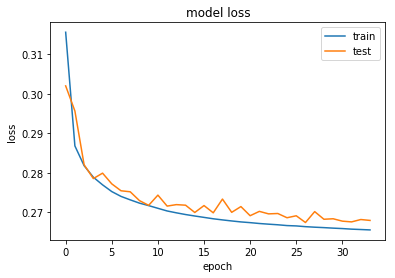

In [5]:
# Evaluate

def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(autoencoder_history)

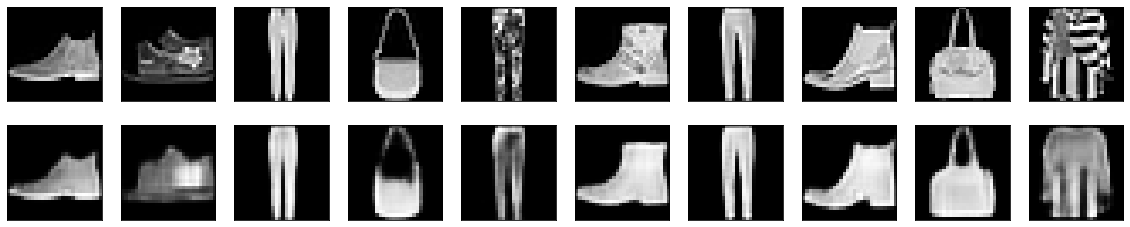

In [6]:
# Display original and reconstruction Images

decoded_imgs = autoencoder.predict(x_test)

def display_reconstructed(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[-i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[-i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

display_reconstructed(x_test, decoded_imgs, 10)

# 2 Image Classification

We'll continue to use the Fashion MNIST dataset and build a deep convolutional
network for classification.

## 2.1 Deep CNN

Build a deep CNN to classify the images. Provide a brief description of the
architectural choices you've made: kernel sizes, strides, padding, network depth.
Train your network end-to-end. Report on your model's performance on training
set and test set.

In [7]:
# Deep CNN

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)

# Data normalization

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

model = Sequential()
# Must define the input shape in the first layer of the neural network
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
__________

In [8]:
eary_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

deep_cnn_history = model.fit(x_train,
                             y_train,
                             batch_size=64,
                             epochs=100,
                             validation_data=(x_test, y_test),
                             callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 73s 1ms/step - loss: 0.6009 - acc: 0.7792 - val_loss: 0.3935 - val_acc: 0.8604
Epoch 2/100
60000/60000 [==============================] - 78s 1ms/step - loss: 0.4146 - acc: 0.8502 - val_loss: 0.3545 - val_acc: 0.8682
Epoch 3/100
60000/60000 [==============================] - 70s 1ms/step - loss: 0.3708 - acc: 0.8644 - val_loss: 0.3130 - val_acc: 0.8864
Epoch 4/100
60000/60000 [==============================] - 78s 1ms/step - loss: 0.3442 - acc: 0.8728 - val_loss: 0.3075 - val_acc: 0.8865
Epoch 5/100
60000/60000 [==============================] - 74s 1ms/step - loss: 0.3268 - acc: 0.8800 - val_loss: 0.3022 - val_acc: 0.8884
Epoch 6/100
60000/60000 [==============================] - 74s 1ms/step - loss: 0.3090 - acc: 0.8867 - val_loss: 0.2761 - val_acc: 0.8995
Epoch 7/100
60000/60000 [==============================] - 76s 1ms/step - loss: 0.2964 - acc: 0.8908 - val_loss: 0.2648 - 

10000/10000 [==============================] - 3s 292us/step
The test score: [0.2173213246524334, 0.9236]


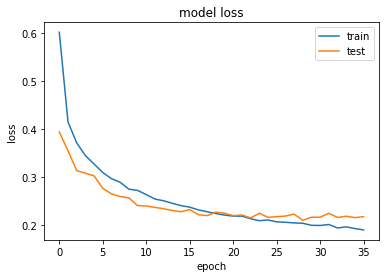

In [9]:
# Evaluate and Plot history

score = model.evaluate(x_test, y_test, verbose=1)

print("The test score: {acc}".format(acc = score))


def plot_train_history_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_train_history_loss(deep_cnn_history)

## 2.2 Transfer Learning

Repeat the same task, but this time utilize a pre-trained network for the major-
ity of your model. You should only train the final Dense layer, all other weights should be fixed. You can use whichever pre-trained backbone you like (ResNet,VGG, etc). Report on your model's performance on training set and test set.

In [10]:
# Transfer Learning

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 784).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 784).astype('float32')

# Convert the images into 3 channels
x_train=np.dstack([x_train] * 3)
x_test=np.dstack([x_test]*3)

x_train = x_train.reshape(x_train.shape[0],28,28,3).astype('float32')
x_test = x_test.reshape(x_test.shape[0],28,28,3).astype('float32')

x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in x_test])

print(x_train.shape) #(60,000*785)
print(x_test.shape) #(10000,785)

x_train = x_train / 255
x_test = x_test / 255

#label for each image
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

(60000, 48, 48, 3)
(10000, 48, 48, 3)


In [11]:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

x_train = preprocess_input(x_train)
x_test  = preprocess_input (x_test)

vgg = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [12]:
# Extracting features

train_features = vgg.predict(np.array(x_train), batch_size=BATCH_SIZE, verbose=1)
test_features = vgg.predict(np.array(x_test), batch_size=BATCH_SIZE, verbose=1)

print(train_features.shape, "\n",  test_features.shape)

10000/10000 [==============================] - 173s 17ms/step
(60000, 1, 1, 512) 
 (10000, 1, 1, 512)


In [13]:
# # Flatten extracted features

train_features_flat = np.reshape(train_features, (60000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))

In [14]:
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_EPOCHS = 100

trans_model = Sequential()
trans_model.add(Dense(512, activation='relu', input_dim=(1*1*512)))
trans_model.add(LeakyReLU(alpha=0.1))
trans_model.add(Dense(10, activation='softmax'))

trans_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['acc'])

trans_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 267,786
Trainable params: 267,786
Non-trainable params: 0
_________________________________________________________________


In [15]:
eary_stopping = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

transfer_history = trans_model.fit(
    train_features_flat,
    y_train,
    epochs=NB_EPOCHS,
    callbacks=callbacks
)

Epoch 1/100
60000/60000 [==============================] - 14s 229us/step - loss: 1.3918 - acc: 0.4856
Epoch 2/100
60000/60000 [==============================] - 13s 223us/step - loss: 1.0313 - acc: 0.6220
Epoch 3/100
60000/60000 [==============================] - 14s 226us/step - loss: 0.9501 - acc: 0.6508
Epoch 4/100
60000/60000 [==============================] - 13s 224us/step - loss: 0.9056 - acc: 0.6693
Epoch 5/100
60000/60000 [==============================] - 13s 224us/step - loss: 0.8794 - acc: 0.6777
Epoch 6/100
60000/60000 [==============================] - 13s 223us/step - loss: 0.8637 - acc: 0.6834
Epoch 7/100
60000/60000 [==============================] - 13s 223us/step - loss: 0.8409 - acc: 0.6915
Epoch 8/100
60000/60000 [==============================] - 14s 227us/step - loss: 0.8336 - acc: 0.6928
Epoch 9/100
60000/60000 [==============================] - 14s 226us/step - loss: 0.8206 - acc: 0.6987
Epoch 10/100
60000/60000 [==============================] - 13s 223us/ste

60000/60000 [==============================] - 13s 224us/step - loss: 0.6695 - acc: 0.7525
Epoch 80/100
60000/60000 [==============================] - 13s 225us/step - loss: 0.6680 - acc: 0.7553
Epoch 81/100
60000/60000 [==============================] - 13s 225us/step - loss: 0.6681 - acc: 0.7560
Epoch 82/100
60000/60000 [==============================] - 13s 223us/step - loss: 0.6685 - acc: 0.7544
Epoch 83/100
60000/60000 [==============================] - 14s 226us/step - loss: 0.6677 - acc: 0.7550
Epoch 84/100
60000/60000 [==============================] - 13s 223us/step - loss: 0.6664 - acc: 0.7541
Epoch 85/100
60000/60000 [==============================] - 13s 224us/step - loss: 0.6651 - acc: 0.7548
Epoch 86/100
60000/60000 [==============================] - 13s 225us/step - loss: 0.6635 - acc: 0.7554
Epoch 87/100
60000/60000 [==============================] - 13s 224us/step - loss: 0.6645 - acc: 0.7575
Epoch 88/100
60000/60000 [==============================] - 13s 223us/step - 

In [16]:
# Evaluate the model 
score = trans_model.evaluate(test_features_flat, y_test, verbose=0)
print('Test Loss and Accuracy:', score)

Test Loss and Accuracy: [0.6750262992858886, 0.7602]


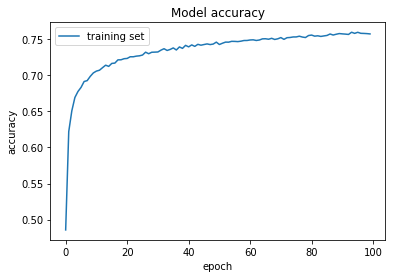

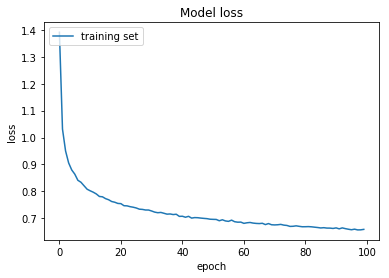

In [17]:
# Accuracy visualization
training_accuracy = transfer_history.history['acc']
plt.plot(training_accuracy)
plt.title('Model accuracy')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Loss visualization

training_loss = transfer_history.history['loss']
plt.plot(training_loss)
plt.title('Model loss')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

# 3 Text Classification

While images contain local spatial correlations and structure, many other datasets
contain temporal correlations. Examples include time series and discrete se-
quences such as text. In this problem, we will tackle the task of text classifica-
tion in the context of cybersecurity.

**Background.** When malware infects a host computer, it often needs to
reach out to an outside server for further instructions or to download additional
payloads. This outside server is called a Command-and-Control server (C2).
The malware needs to send a specific communication to the C2 server, thus the
C2 server needs to have a registered IP address or associated web domain so
that it can be reached. Therefore, being able to identify web domains that are
likely related to malware C2 can be a valuable cyber defense.

**Dataset.** Fortunately, security researchers have already identified and logged
a large number of malicious URLs. Additionally, we can catalog common "be-
nign" URLs just from typical web behavior (these would include things like
facebook.com and amazon.com). Hence, we have a labeled dataset for text
classification which can be downloaded here:

* https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt

* https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt


## 3.1 RNN

Build and train a Recurrent Neural Network to solve this text classification task.
You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).

In [18]:
# Text Classification

# Load Malicious Url

with open("malicious-urls.txt") as files:
    lines = files.readlines()
mal_url_strings = [line.rstrip("\n\r") for line in lines[0:]]

with open("benign-urls.txt") as files:
    lines = files.readlines()
ben_url_strings = [line.rstrip("\n\r") for line in lines[0:] if "#" not in line]

In [19]:
x_train = ben_url_strings + mal_url_strings
y_train = np.concatenate( [ np.ones(len(ben_url_strings)), np.zeros(len(mal_url_strings)) ])

In [20]:
df = pd.DataFrame({'urls':x_train, 'label':y_train})

# Step 1: Convert raw URL string in list of lists where characters that are contained in "printable" are stored encoded as integer 
url_int_tokens = [[printable.index(x) + 1 for x in url if x in printable] for url in df.urls]

# Step 2: Cut URL string at max_len or pad with zeros if shorter
max_len=75
X = pad_sequences(url_int_tokens, maxlen=max_len)
 
# Step 3: Extract labels form df to numpy array
target = np.array(df.label)

print('Matrix dimensions of X: ', X.shape, 'Vector dimension of target: ', target.shape)

Matrix dimensions of X:  (67311, 75) Vector dimension of target:  (67311,)


In [21]:
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.25, random_state=33)

In [22]:
# LSTM Model

max_len=75
emb_dim=32
max_vocab_len=100
lstm_output_size=32
W_reg=regularizers.l2(1e-4)

main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
# Embedding layer
emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
            dropout=0.2, W_regularizer=W_reg)(main_input) 

# LSTM layer
lstm = LSTM(lstm_output_size)(emb)
lstm = Dropout(0.5)(lstm)

# Output layer (last fully connected layer)
output = Dense(1, activation='sigmoid', name='output')(lstm)

# Compile model and define optimizer
model = Model(input=[main_input], output=[output])
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 32)            3200      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________


In [23]:
epochs = 100
batch_size = 32

eary_stopping = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

model.fit(X_train, target_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/100
50483/50483 [==============================] - 63s 1ms/step - loss: 0.1510 - acc: 0.9793
Epoch 2/100
50483/50483 [==============================] - 63s 1ms/step - loss: 0.0824 - acc: 0.9812
Epoch 3/100
50483/50483 [==============================] - 70s 1ms/step - loss: 0.0586 - acc: 0.9812
Epoch 4/100
50483/50483 [==============================] - 83s 2ms/step - loss: 0.0458 - acc: 0.9811
Epoch 5/100
50483/50483 [==============================] - 78s 2ms/step - loss: 0.0375 - acc: 0.9817
Epoch 6/100
50483/50483 [==============================] - 78s 2ms/step - loss: 0.0320 - acc: 0.9834
Epoch 7/100
50483/50483 [==============================] - 78s 2ms/step - loss: 0.0292 - acc: 0.9852: 1s - loss: 0
Epoch 8/100
50483/50483 [==============================] - 78s 2ms/step - loss: 0.0281 - acc: 0.9866
Epoch 9/100
50483/50483 [==============================] - 78s 2ms/step - loss: 0.0265 - acc: 0.9875
Epoch 10/100
50483/50483 [==============================] - 78s 2ms/step - lo

In [24]:
loss, accuracy = model.evaluate(X_test, target_test, verbose=1)
print('\nFinal Cross-Validation Accuracy', accuracy, '\n')

16828/16828 [==============================] - 5s 290us/step

Final Cross-Validation Accuracy 0.9890064178608023 



## 3.2 CNN

Build and train a 1D CNN for this text classification task. You might gain some
insight and inspiration from these text classification approaches:

* http://www.aclweb.org/anthology/D14-1181

* https://arxiv.org/abs/1702.08568

In [25]:
# CNN Model

max_len=75
emb_dim=32
max_vocab_len=100
W_reg=regularizers.l2(1e-4)

# Input
main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
# Embedding layer
emb = Embedding(input_dim=max_vocab_len, output_dim=emb_dim, input_length=max_len,
            W_regularizer=W_reg)(main_input) 
emb = Dropout(0.25)(emb)


def sum_1d(X):
    return K.sum(X, axis=1)

def get_conv_layer(emb, kernel_size=5, filters=256):
    # Conv layer
    conv = Convolution1D(kernel_size=kernel_size, filters=filters, \
                 border_mode='same')(emb)
    conv = ELU()(conv)

    conv = Lambda(sum_1d, output_shape=(filters,))(conv)
    #conv = BatchNormalization(mode=0)(conv)
    conv = Dropout(0.5)(conv)
    return conv

# Multiple Conv Layers

# calling custom conv function from above
conv1 = get_conv_layer(emb, kernel_size=2, filters=256)
conv2 = get_conv_layer(emb, kernel_size=3, filters=256)
conv3 = get_conv_layer(emb, kernel_size=4, filters=256)
conv4 = get_conv_layer(emb, kernel_size=5, filters=256)

# Fully Connected Layers
merged = concatenate([conv1,conv2,conv3,conv4], axis=1)

hidden1 = Dense(1024)(merged)
hidden1 = ELU()(hidden1)
hidden1 = BatchNormalization(mode=0)(hidden1)
hidden1 = Dropout(0.5)(hidden1)

hidden2 = Dense(1024)(hidden1)
hidden2 = ELU()(hidden2)
hidden2 = BatchNormalization(mode=0)(hidden2)
hidden2 = Dropout(0.5)(hidden2)

# Output layer (last fully connected layer)
output = Dense(1, activation='sigmoid', name='output')(hidden2)

# Compile model and define optimizer
cnn_model = Model(input=[main_input], output=[output])
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
cnn_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 75)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 75, 32)       3200        main_input[0][0]                 
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 75, 32)       0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 75, 256)      16640       dropout_5[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [26]:
epochs = 100
batch_size = 32

eary_stopping = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [eary_stopping]

cnn_model.fit(X_train, target_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/100
50483/50483 [==============================] - 126s 2ms/step - loss: 0.3499 - acc: 0.8562
Epoch 2/100
50483/50483 [==============================] - 135s 3ms/step - loss: 0.1220 - acc: 0.9727
Epoch 3/100
50483/50483 [==============================] - 135s 3ms/step - loss: 0.1074 - acc: 0.9752
Epoch 4/100
50483/50483 [==============================] - 134s 3ms/step - loss: 0.0955 - acc: 0.9760
Epoch 5/100
50483/50483 [==============================] - 133s 3ms/step - loss: 0.0820 - acc: 0.9770
Epoch 6/100
50483/50483 [==============================] - 135s 3ms/step - loss: 0.0759 - acc: 0.9774
Epoch 7/100
50483/50483 [==============================] - 135s 3ms/step - loss: 0.0676 - acc: 0.9791
Epoch 8/100
50483/50483 [==============================] - 135s 3ms/step - loss: 0.0614 - acc: 0.9794
Epoch 9/100
50483/50483 [==============================] - 135s 3ms/step - loss: 0.0568 - acc: 0.9804
Epoch 10/100
50483/50483 [==============================] - 136s 3ms/step - loss: 

In [27]:
loss, accuracy = cnn_model.evaluate(X_test, target_test, verbose=1)
print('\nFinal Cross-Validation Accuracy', accuracy, '\n')

16828/16828 [==============================] - 11s 643us/step

Final Cross-Validation Accuracy 0.9882933206135456 



## 3.3

Be sure to directly compare your two methods with an ROC curve or similar
validation method. Don't forget to create a train-test split.

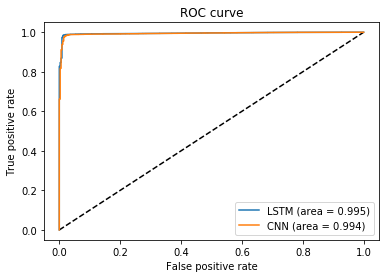

In [28]:
# LSTM and CNN ROC Curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(target_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

cnn_y_pred_keras = cnn_model.predict(X_test).ravel()
cnn_fpr_keras, cnn_tpr_keras, cnn_thresholds_keras = roc_curve(target_test, cnn_y_pred_keras)
cnn_auc_keras = auc(cnn_fpr_keras, cnn_tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='LSTM (area = {:.3f})'.format(auc_keras))
plt.plot(cnn_fpr_keras, cnn_tpr_keras, label='CNN (area = {:.3f})'.format(cnn_auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()